In [1]:
import pandas as pd
import numpy as np
import torch

from pathlib import Path
from PIL import Image

from src.model import ResModel
from torchvision.transforms.functional import pil_to_tensor

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = '/home/chernogor/workspace/mag/signals/cnnimagecodec/exp/nonorm/eval/log.csv'

In [3]:
df = pd.read_csv(path, header=None, names=['type', 'ep', 'val'])
print(len(df))
df.head()

205


,type,ep,val
0,Loss,0,0.060671
1,Val,0,0.029683
2,Loss,1,0.062926
3,Loss,2,0.060438
4,Loss,3,0.050669


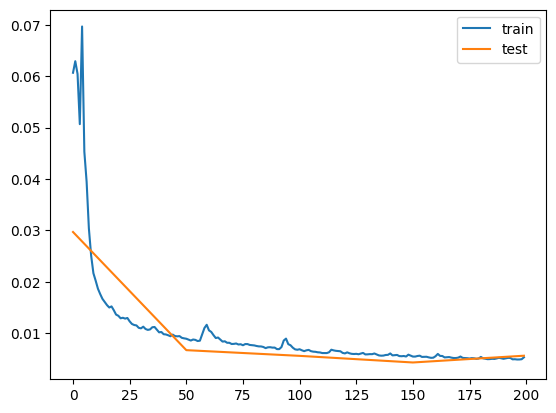

In [4]:
plt.plot(df.loc[df['type'] == 'Loss', 'ep'], df.loc[df['type'] == 'Loss', 'val'], label='train')
plt.plot(df.loc[df['type'] == 'Val', 'ep'], df.loc[df['type'] == 'Val', 'val'], label='test')
plt.legend()

## Show

In [7]:
test_pth = Path('./test')
img_pths = list(test_pth.iterdir())
print(img_pths)

[PosixPath('test/6.png'), PosixPath('test/7.png'), PosixPath('test/12.png'), PosixPath('test/5.png'), PosixPath('test/1.png'), PosixPath('test/4.png'), PosixPath('test/20.png'), PosixPath('test/2.png'), PosixPath('test/9.png'), PosixPath('test/10.png'), PosixPath('test/16.png'), PosixPath('test/8.png'), PosixPath('test/19.png'), PosixPath('test/11.png'), PosixPath('test/14.png'), PosixPath('test/15.png'), PosixPath('test/3.png'), PosixPath('test/18.png'), PosixPath('test/21.png'), PosixPath('test/13.png'), PosixPath('test/17.png')]


10 255


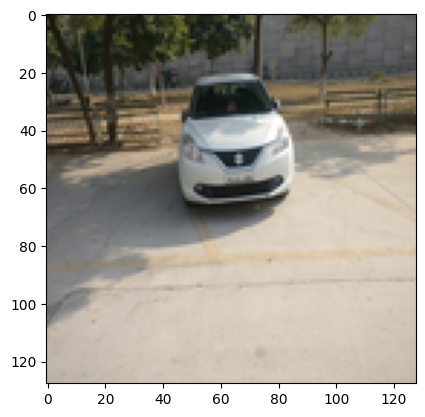

In [10]:
img = np.asarray(Image.open(img_pths[0]))
print(img.min(), img.max())
plt.imshow(img)

In [13]:
model_pth = './exp/nonorm/models'

model = ResModel()
model.enc.load_state_dict(torch.load(f'{model_pth}/enc150.pt', weights_only=True))
model.dec.load_state_dict(torch.load(f'{model_pth}/dec150.pt', weights_only=True))
model.eval()

ResModel(
  (enc): Sequential(
    (0): Conv2d(3, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): GELU(approximate='none')
    (2): ResBlock(
      (l1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (l2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): GELU(approximate='none')
    )
    (3): Conv2d(128, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): GELU(approximate='none')
    (5): ResBlock(
      (l1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (l2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): GELU(approximate='none')
    )
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): GELU(approximate='none')
    (8): ResBlock(
      (l1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (l2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): GELU(approx

In [25]:
# timg = torch.Tensor(img / 255).permute(2, 0, 1)
timg = pil_to_tensor(Image.open(img_pths[0])) / 255
print(timg.shape)

print(timg.max(), timg.min())
with torch.no_grad():
    out = model(timg)
print(out.shape)

torch.Size([3, 128, 128])
tensor(1.) tensor(0.0392)
torch.Size([3, 128, 128])


0.9528199 0.023772718


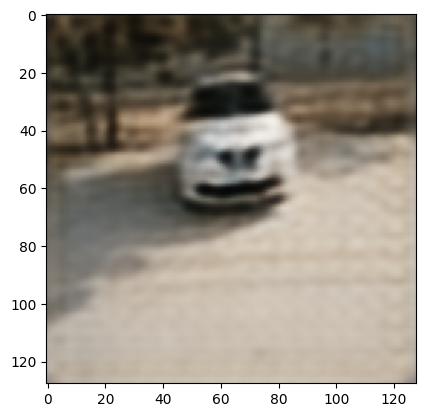

In [26]:
oimg = out.permute(1, 2, 0).numpy()
print(oimg.max(), oimg.min())
plt.imshow(oimg)

In [ ]:
for imp in img_pths:
    
    timg = torch.Tensor(img / 255).permute(2, 0, 1)
    with torch.no_grad():
        out = model(timg)
    

## Check result csv

In [42]:
df = pd.read_csv('res/result2.csv')
df.head()

,Unnamed: 0,bpp_base,ssim_base,bpp_solution,ssim_solution,bpp_jpeg,ssim_jpeg
0,0,0.5230,0.551588,0.3594,0.565374,0.469238,0.561174
1,1,0.4770,0.566994,0.3613,0.616823,0.460938,0.589880
2,2,0.5290,0.557931,0.3022,0.486258,0.476074,0.492703
3,3,0.4746,0.522424,0.3838,0.477603,0.483398,0.476819
4,4,0.5356,0.566284,0.3228,0.521573,0.476074,0.494466


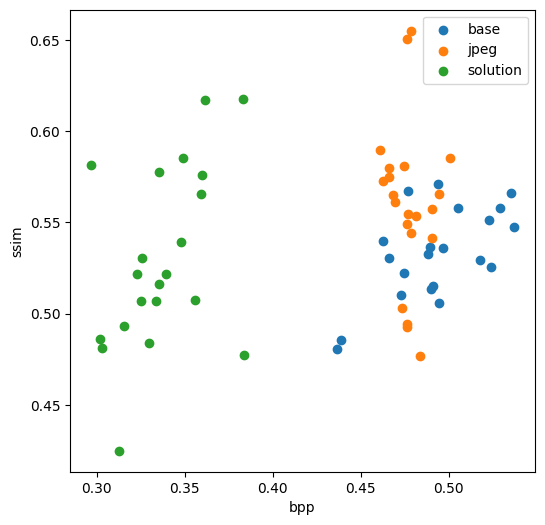

In [43]:
f, ax = plt.subplots(figsize=(6, 6))
for name in ['base', 'jpeg', 'solution']:
    bn = f'bpp_{name}'
    sn = f'ssim_{name}'
    df1 = df.sort_values(by=bn)
    ax.scatter(df[bn], df[sn], label=name)
ax.set_xlabel('bpp')
ax.set_ylabel('ssim')
ax.legend()

SSIM MSE: 0.001893137366952028
BPP MSE: 0.02592834238095238


Text(0.5, 1.0, 'Mean SSIM: 0.53 vs 0.53')

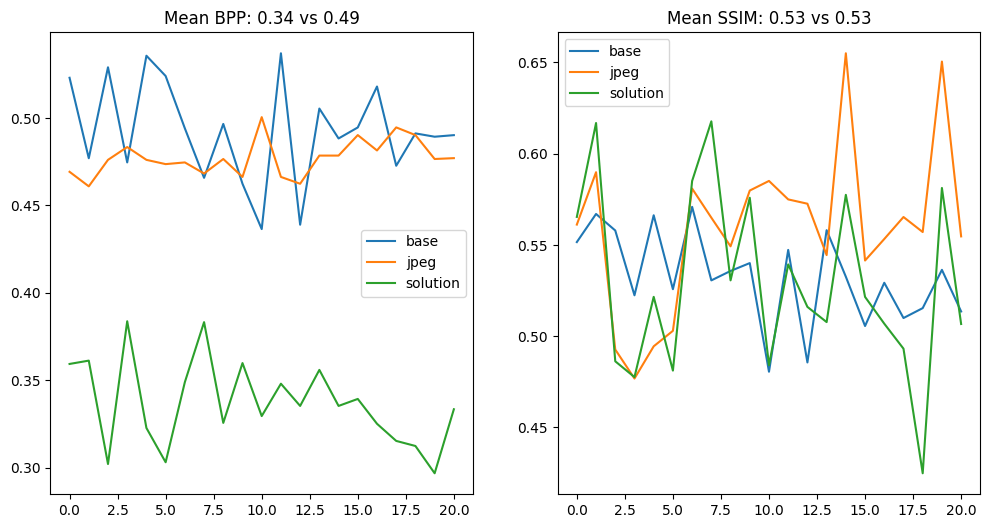

In [44]:
print('SSIM MSE:', ((df['ssim_base'] - df['ssim_solution'])**2).mean())
print('BPP MSE:', ((df['bpp_base'] - df['bpp_solution'])**2).mean())
bpp1 = df['bpp_base'].mean()
bpp2 = df['bpp_solution'].mean()
ssim1 = df['ssim_base'].mean()
ssim2 = df['ssim_solution'].mean()
f, (a0, a1) = plt.subplots(1, 2, figsize=(12, 6))
a0.plot(df.index, df['bpp_base'], label='base')
a0.plot(df.index, df['bpp_jpeg'], label='jpeg')
a0.plot(df.index, df['bpp_solution'], label='solution')
a1.plot(df.index, df['ssim_base'], label='base')
a1.plot(df.index, df['ssim_jpeg'], label='jpeg')
a1.plot(df.index, df['ssim_solution'], label='solution')
a0.legend()
a1.legend()
a0.set_title(f'Mean BPP: {bpp2:.2f} vs {bpp1:.2f}')
a1.set_title(f'Mean SSIM: {ssim2:.2f} vs {ssim1:.2f}')

In [22]:
resp = Path('res')

In [27]:
xs = np.arange(2, 6)
names = ['base', 'solution', 'jpeg']
bpps = [[], [], []]
ssims = [[], [], []]
for x in xs:
    df = pd.read_csv(f'res/result{x}.csv')
    m = df.mean(axis=0)
    for i, n in enumerate(names):
        bpps[i].append(m[f'bpp_{n}'])
        ssims[i].append(m[f'ssim_{n}'])

При увеличении b модель отстает от jpeg и базовой модели по качеству, но при этом сохраняет выигрыш по сжатию.

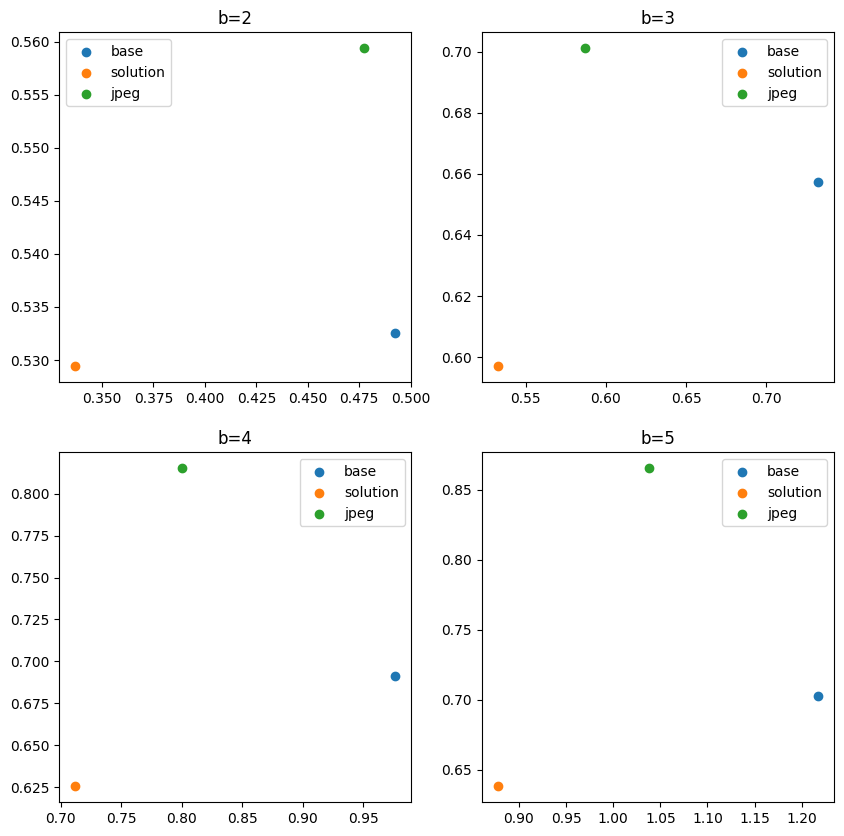

In [32]:
f, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, (b, ax) in enumerate(zip(xs, axs.flatten())):
    for j, n in enumerate(names):
        ax.scatter(bpps[j][i], ssims[j][i], label=n)
    ax.set_title(f'b={b}')
    ax.legend()